Since September 2013 I've been organising shitey (pronounced shy-tee) film nights in my _alma mater_ Institute of Evolutionary Biology at the University of Edinburgh until the time when I left for Fred Hutchinson Cancer Research Center in Seattle in March 2016.

The idea has been to get PhD students together on Fridays when Happy Hour wasn't going on (which is once every two weeks) to watch films that are so bad they're good. Because relatively few people were involved the Friday film nights were quite flexible, such that we ended up watching good films too and mixing good and bad films in the same night. Every shitey film night was announced by email, which enabled me to reconstruct the order in which films were shown, when the films were released, what their scores on IMDb were, whether a film was shown first or second within a night, who organised the night, _etc_.

This Jupyter notebook is intended to show rolling statistics of films watched at my franchise of shitey film nights. By the time I left Edinburgh 63 films were shown at shitey film night.

The notebook presents some basic non-parametric analyses of films based on their quality as determined by IMDb scores. Of all associations tested so far only the correlation between the IMDb score of the first and second films in nights when films were double-billed is significant. Otherwise there is no apparent relationship between when a film was shown or released, whether a film was shown first or second within the night and its IMDb score.

TO DO:


In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib import gridspec
#from matplotlib.ticker import MultipleLocator, FormatStrFormatter
#import matplotlib.patches as patches
#from matplotlib.patches import Polygon
#from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import spearmanr,mannwhitneyu,gaussian_kde

import colorsys
import os
import re
import datetime as dt
import sys
import platform
import time

## set default matplotlib font and font size
typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
print '%-20s%10s (%s)'%('Operating system:',platform.system(),platform.release())
print '%-20s%10s'%('Python version:','.'.join(map(str,sys.version_info[:3])))
print '%-20s%10s'%('Numpy version:',np.__version__)
print '%-20s%10s'%('Pandas version:',pd.__version__)
print '%-20s%10s'%('matplotlib version:',mpl.__version__)
# print '%-20s%10s'%('scipy version:',scipy_version)
print '\nThis notebook was last run on:\n%s\t%s'%(dt.datetime.strftime(dt.datetime.now(),'%A\t%Y-%b-%d\t%H:%M'),time.tzname[time.daylight])

def index(data,item):
    return [i for i,x in enumerate(data) if x == item]

def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)

def decimalDate(date,fmt="%Y-%m-%d"):
    adatetime=dt.datetime.strptime(date,fmt)
    year = adatetime.year
    boy = dt.datetime(year, 1, 1)
    eoy = dt.datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

def unique(o, idfun=repr):
    """
    Returns a list of unique values in a list.
    """
    seen = {}
    return [seen.setdefault(idfun(e),e) for e in o if idfun(e) not in seen]

def column(data,col):
    """
    Returns a list that is a column in a list of lists.
    """
    return [row [col] for row in data]


Operating system:       Darwin (15.4.0)
Python version:         2.7.11
Numpy version:          1.10.4
Pandas version:         0.17.1
matplotlib version:      1.5.1

This notebook was last run on:
Thursday	2016-May-05	11:27	PDT


In [2]:
spreadsheet='/Users/evogytis/Documents/ShMDb/The Room aka data/Shitey (pronounced shy-tee) film night catalogue - Sheet1.tsv'
# spreadsheet='E:\\Downloads\\Shitey (pronounced shy-tee) film night catalogue - Sheet1.tsv'

all_films=[]

imdb_dict={}
night_films={}

for line in open(spreadsheet,'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='film':
        header=l
        print header
    else:
        all_films.append(l)
        
        if l[2]!='':
            imdb_dict[l[0]]=float(l[2])
        if night_films.has_key(l[4]):
            night_films[l[4]].append(l[0])
        else:
            night_films[l[4]]=[l[0]]
        
film_names=column(all_films,0)
release_year=map(int,column(all_films,1))
IMDb_scores=[float(x) if x!='' else np.nan for x in column(all_films,2)]
goodness=column(all_films,3)
shown_on=[decimalDate(x,'%d/%m/%Y') for x in column(all_films,4)]
order_in_night=map(int,column(all_films,5))
advertised_as=column(all_films,6)
place=column(all_films,7)
shown_by=column(all_films,8)
billed_with=column(all_films,9)
keywords=column(all_films,10)
notes=column(all_films,11)

timeline=['2013-%02d-01'%(x) for x in range(9,13)]
timeline+=['2014-%02d-01'%(x) for x in range(1,13)]
timeline+=['2015-%02d-01'%(x) for x in range(1,13)]
timeline+=['2016-%02d-01'%(x) for x in range(1,int(dt.datetime.strftime(dt.datetime.now(),'%m'))+2)]
digital_timeline=map(decimalDate,timeline)

print len(all_films)

pd_films=pd.read_csv(spreadsheet,sep='\t')
pd_films.head()

#pd_films.describe()

['film', 'year', 'IMDb score', 'good', 'date shown', 'order', 'tagline', 'place', 'shown by', 'billed with', 'keywords', 'notes\r']
70


,film,year,IMDb score,good,date shown,order,tagline,place,shown by,billed with,keywords,notes
0,The Room,2003,3.5,no,20/09/2013,1,Shitey (pronounced shy-tee) movie night ^_^,Ashworth,Gytis Dudas,Troll 2,NaN,Very first shitey film night in Ashworth
1,Troll 2,1990,2.7,no,20/09/2013,2,Shitey (pronounced shy-tee) movie night ^_^,Ashworth,Gytis Dudas,The Room,NaN,Very first shitey film night in Ashworth
2,Atlantic Rim,2013,1.7,no,11/10/2013,1,Shitey (pronounced shy-tee) movie night 2.0 ^_...,Ashworth,Gytis Dudas,Die Hard Dracula,NaN,Asylum Pictures film
3,Die Hard Dracula,1998,1.8,no,11/10/2013,2,Shitey (pronounced shy-tee) movie night 2.0 ^_...,Ashworth,Gytis Dudas,Atlantic Rim,NaN,Night when Die Hard Dracula was discovered
4,The Evil Dead,1981,7.5,yes,25/10/2013,1,Shitey film night! (Fri 25 Oct),Ashworth,Gytis Dudas,Evil Dead II,Evil Dead,Very first good film night in Ashworth



Oldest film ever shown: Manos the Hands of Fate (1966)

Newest film ever shown: Ash vs Evil Dead (2015)

Worse film ever shown (according to IMDb): Atlantic Rim (1.7)

Best film ever shown (according to IMDb): Ash vs Evil Dead (9.3)


Army of Darkness + Ash vs Evil Dead (mean IMDb score: 8.45)
Dr. Horrible's Sing Along Blog  + Commentary! The Musical (mean IMDb score: 8.35)
V for Vendetta (mean IMDb score: 8.20)
Thank You for Smoking + Kiss Kiss Bang Bang (mean IMDb score: 7.70)
The Darjeeling Limited + The Grand Budapest Hotel (mean IMDb score: 7.70)
The Evil Dead + Evil Dead II (mean IMDb score: 7.65)
Princess Bride + Robin Hood: Men In Tights (mean IMDb score: 7.45)
Prometheus + Predator (mean IMDb score: 7.40)
The Mist + Carrie (mean IMDb score: 7.30)
They Live! + Big Troube in Little China (mean IMDb score: 7.30)
They Live! (mean IMDb score: 7.30)
Conan the Barbarian + Total Recall (mean IMDb score: 7.20)
The Rainbow + Women in Love (mean IMDb score: 6.95)
The Room + Kung Fury + 

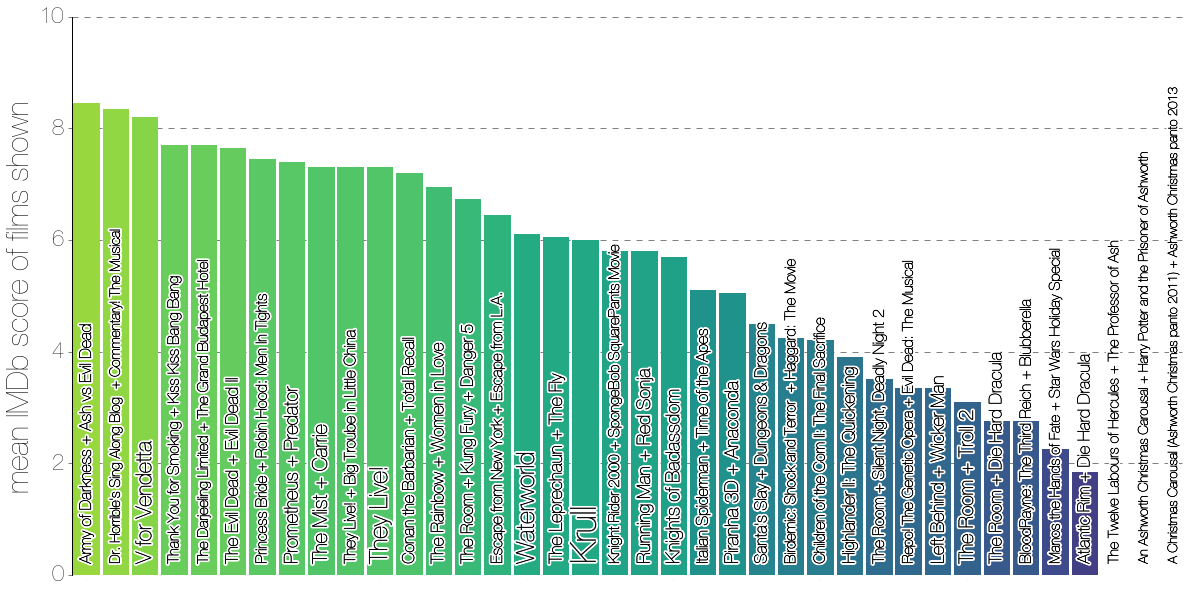

36 6 28


In [3]:
oldest=release_year.index(min(release_year))
print '\nOldest film ever shown: %s (%d)'%(film_names[oldest],min(release_year))

newest=release_year.index(max(release_year))
print '\nNewest film ever shown: %s (%d)'%(film_names[newest],max(release_year))

worst=IMDb_scores.index(min(IMDb_scores))
print '\nWorse film ever shown (according to IMDb): %s (%.1f)'%(film_names[worst],min(IMDb_scores))

best=IMDb_scores.index(max(IMDb_scores))
print '\nBest film ever shown (according to IMDb): %s (%.1f)'%(film_names[best],max(IMDb_scores))

print '\n'
worst_night=sorted([(n,sum([imdb_dict[s] for s in n if imdb_dict.has_key(s)])/float(len(n))) for n in night_films.values()],key=lambda x:-x[1])
##print worst_night

fig,ax = plt.subplots(figsize=(20, 10),facecolor='w')

xlabels=[]
for n,night in enumerate(worst_night):
    #print night
    films,sumscore=night
    meanscore=sumscore
    films=' + '.join(films)
    xlabels.append(films)
    print '%s (mean IMDb score: %.2f)'%(films,meanscore)
    if np.isnan(meanscore)==False:
        ax.bar(n,meanscore,facecolor=mpl.cm.viridis(meanscore/10.0),edgecolor='none',align='center',width=0.9,zorder=10)

    effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]
    ax.text(n,0.2,films,size=25/np.log10(len(films)),va='bottom',ha='center',rotation=90,path_effects=effects,zorder=11)
    
ax.set_ylim(0,10)
ax.set_xlim(-0.5,len(worst_night)-0.5)
ax.set_ylabel('mean IMDb score of films shown',size=30)
#ax.set_xticks(range(len(xlabels)))
#ax.set_xticklabels(xlabels,path_effects=effects,rotation=90)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(axis='x',size=0,labelsize=0)
ax.tick_params(axis='y',direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(axis='y',ls='--',zorder=0)

plt.show()
print goodness.count('no'),goodness.count('maybe'),goodness.count('yes')

Mean IMDb score: 5.72
standard deviation: 2.18


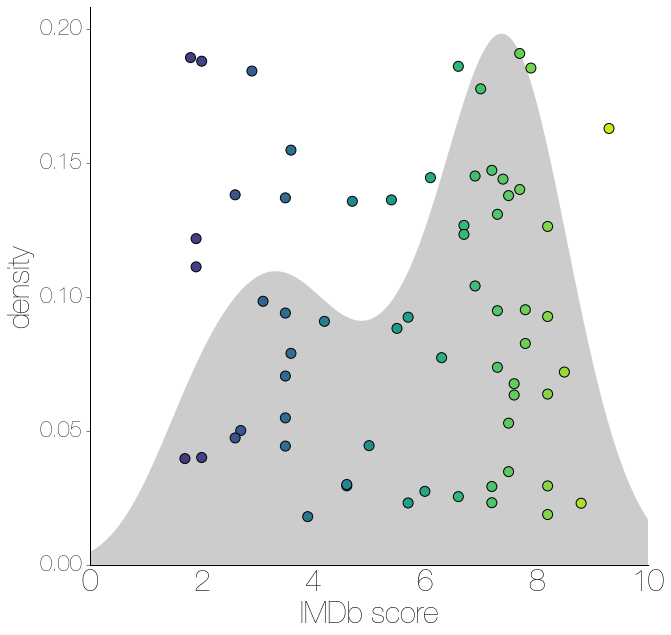

In [4]:
fig,ax = plt.subplots(figsize=(10, 10),facecolor='w')

scores=[x for x in IMDb_scores if np.isnan(x)==False]
print 'Mean IMDb score: %.2f\nstandard deviation: %.2f'%(np.mean(scores),np.std(scores))

x_grid=np.linspace(0,10,200)
kde = gaussian_kde(scores,bw_method=0.4) #calculates the kernel density
v1 = kde.evaluate(x_grid)

#ax.plot(x_grid,v1,color='indianred',lw=3,alpha=1)
ax.fill_between(x_grid,v1,facecolor='k',edgecolor='none',alpha=0.2)

ax.scatter(scores,[np.random.uniform(min(v1)+0.001,max(v1)) for w in scores],s=100,zorder=100,c=[mpl.cm.viridis(w/10.0) for w in scores])

ax.set_ylim(0.0,max(v1)+0.01)
ax.set_xlim(0,10)

ax.tick_params(axis='y',direction='out')
ax.tick_params(axis='x',size=0,labelsize=30)

ax.set_ylabel('density',size=30)
ax.set_xlabel('IMDb score',size=30)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Order: 1 mean score: 5.7771 score stdev: 2.0319
Order: 2 mean score: 5.7185 score stdev: 2.3544
Order: 3 mean score: 3.5000 score stdev: 0.0000
Mann-Whitney U test for differences in IMDb score between films shown first vs films shown second in a shitey film night:
U statistic = 454 (p-value = 0.7982)


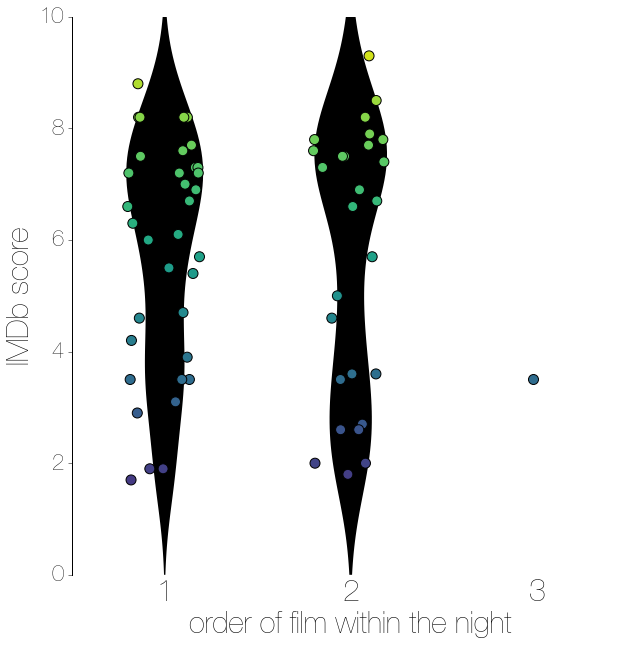

In [5]:
fig,ax = plt.subplots(figsize=(10, 10),facecolor='w')

orders_in_night=unique(sorted(order_in_night))

stat_test={}
for i in orders_in_night:
    scores=[IMDb_scores[x] for x in index(order_in_night,i) if np.isnan(IMDb_scores[x])==False]
    stat_test[i]=scores
    y=np.mean(scores)
    x=i
    
    if len(scores)>1:
        x_grid=np.linspace(0,10,100)
        kde = gaussian_kde(scores,bw_method=0.4) #calculates the kernel density
        v1 = kde.evaluate(x_grid)
        
        ax.fill_betweenx(x_grid,[x-w for w in v1],[x+w for w in v1],facecolor='k',edgecolor='none',alpha=1)
    
    print 'Order: %d mean score: %.4f score stdev: %.4f'%(x,y,np.std(scores))

    ax.scatter([i+np.random.uniform(-0.2,0.2) for w in scores],scores,s=100,zorder=100,c=[mpl.cm.viridis(w/10.0) for w in scores])

print 'Mann-Whitney U test for differences in IMDb score between films shown first vs films shown second in a shitey film night:\nU statistic = %d (p-value = %.4f)'%(mannwhitneyu(stat_test[1],stat_test[2]))
    
ax.set_ylim(0,10)
ax.set_xlim(0.5,len(orders_in_night)+0.5)
ax.set_xticks(orders_in_night)
ax.set_xticklabels(orders_in_night)

ax.tick_params(axis='y',direction='out')
ax.tick_params(axis='x',size=0,labelsize=30)

ax.set_ylabel('IMDb score',size=30)
ax.set_xlabel('order of film within the night',size=30)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Gytis Dudas 58
Liam Brierley 6
Doris Reineke 3
Andres G. de la Filia 3


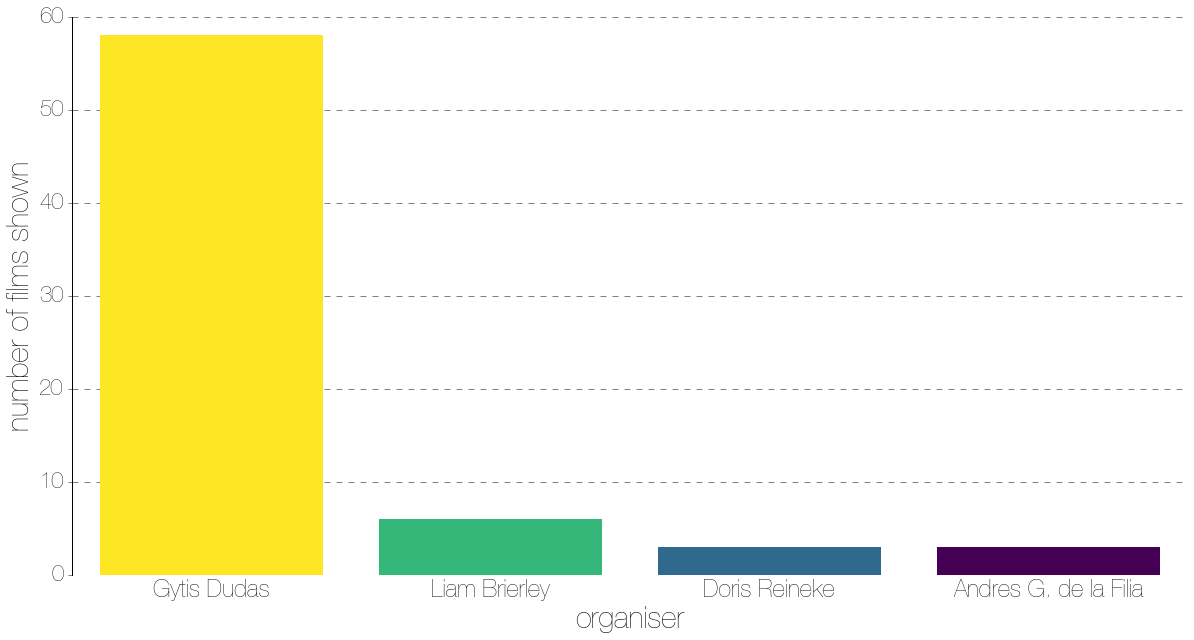

In [6]:
fig,ax = plt.subplots(figsize=(20, 10),facecolor='w')

xs=range(len(unique(shown_by)))
labels=sorted(unique(shown_by),key=lambda x:-shown_by.count(x))
ys=[shown_by.count(organizer) for organizer in labels]
cmap=mpl.cm.viridis_r

for i in xs:
    print labels[i],ys[i]
    ax.bar(i,ys[i],align='center',facecolor=cmap((i)/float(len(xs)-1)),edgecolor='none',label=labels[i],zorder=10)
    
ax.set_xticks(xs)
ax.set_xticklabels(labels,size=24)
# ax.legend()

ax.set_ylabel('number of films shown',size=30)
ax.set_xlabel('organiser',size=30)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',direction='out')
ax.tick_params(axis='x',size=0)

ax.grid(axis='y',ls='--',zorder=0)

plt.show()

Spearman correlation between date of film night and IMDb score: 0.08 (p-value = 0.5434)


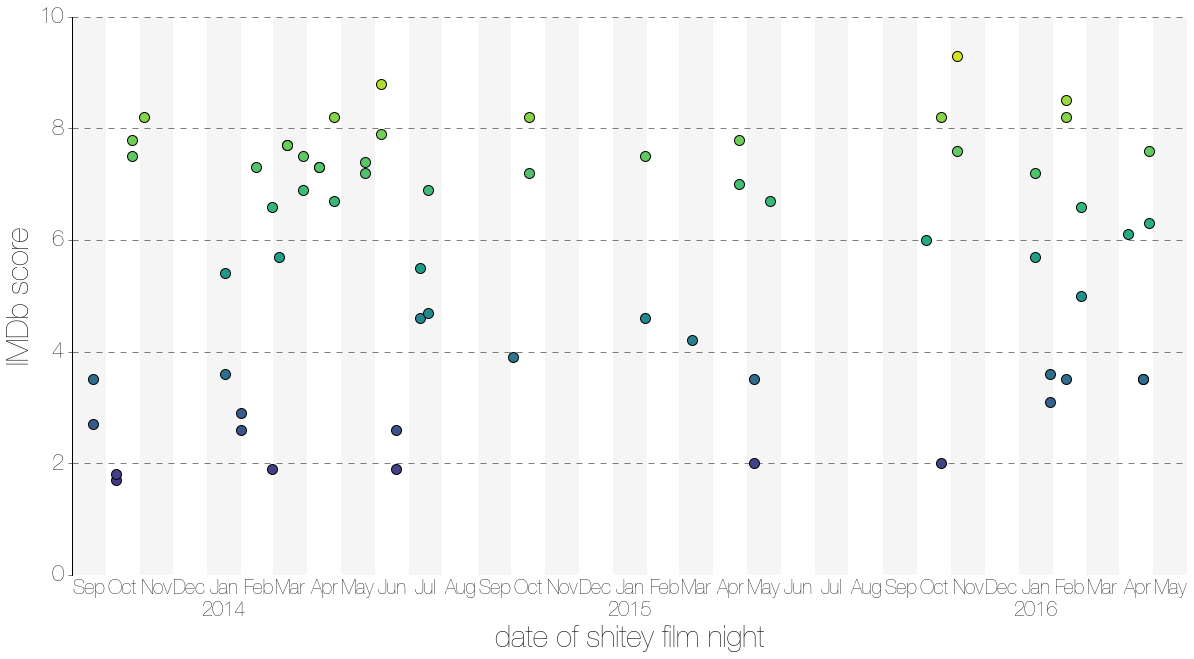

In [7]:
fig,ax = plt.subplots(figsize=(20, 10),facecolor='w')

cmap=mpl.cm.viridis

testx=[]
testy=[]
for w in range(len(IMDb_scores)):
    if np.isnan(IMDb_scores[w])==False:
        c=cmap(IMDb_scores[w]/10.0)
    else:
        c='grey'
    ax.scatter(shown_on[w],IMDb_scores[w],s=100,facecolor=c,zorder=10)
    if c!='grey':
        testx.append(shown_on[w])
        testy.append(IMDb_scores[w])
        
print 'Spearman correlation between date of film night and IMDb score: %.2f (p-value = %.4f)'%(spearmanr(testx,testy))

ax.set_xticks([decimalDate(x)+1/24.0 for x in timeline])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in timeline])

[ax.axvspan(decimalDate(timeline[x]),decimalDate(timeline[x])+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(timeline),2)]

ax.set_ylabel('IMDb score',size=30)
ax.set_xlabel('date of shitey film night',size=30)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',direction='out')
ax.tick_params(axis='x',size=0,labelsize=20)

ax.set_xlim(min(digital_timeline),max(digital_timeline))
ax.set_ylim(0,10)

ax.grid(axis='y',ls='--',zorder=0)

plt.show()

Spearman correlation between year of release and IMDb score: 0.04 (p-value = 0.7453)


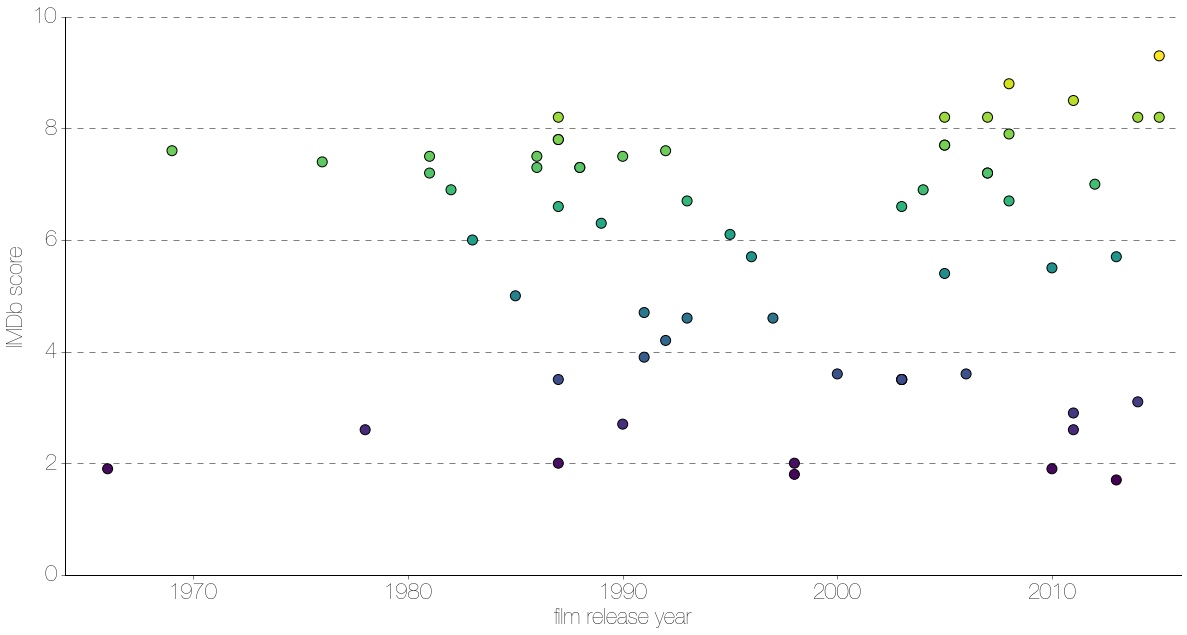

In [8]:
fig,ax = plt.subplots(figsize=(20, 10),facecolor='w')

ax.scatter(release_year,IMDb_scores,s=100,c=IMDb_scores,cmap=mpl.cm.viridis,zorder=10)

ax.set_ylabel('IMDb score')
ax.set_xlabel('film release year')

test=[(x,y) for x,y in zip(release_year,IMDb_scores) if np.isnan(y)==False]
print 'Spearman correlation between year of release and IMDb score: %.2f (p-value = %.4f)'%(spearmanr(column(test,0),column(test,1)))
ax.set_xlim(min(release_year)-2,int(dt.datetime.strftime(dt.datetime.now(),'%Y')))
ax.set_ylim(0,10)

ax.tick_params(direction='out')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y',ls='--',zorder=0)

plt.show()

Spearman correlation coefficient between first and second films in the night: 0.61 (p-value = 0.0009)


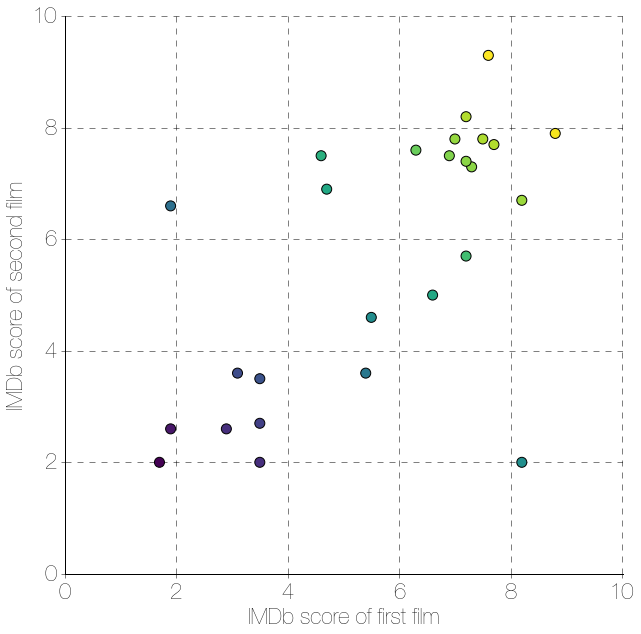

In [9]:
nights=[film_names[i] for i,x in enumerate(shown_on) if shown_on.count(x)==2]

fig,ax = plt.subplots(figsize=(10, 10),facecolor='w')

testx=[]
testy=[]
for i in range(0,len(nights),2):
    film1=nights[i]
    film2=nights[i+1]
    
    if imdb_dict.has_key(film1)==True and imdb_dict.has_key(film2)==True:
        testx.append(imdb_dict[film1])
        testy.append(imdb_dict[film2])

cs=[np.mean([x,y])/10.0 for x,y in zip(testx,testy)]
print 'Spearman correlation coefficient between first and second films in the night: %.2f (p-value = %.4f)'%(spearmanr(testx,testy))
ax.scatter(testx,testy,s=100,c=cs,cmap=mpl.cm.viridis,zorder=10)

ax.set_xlabel('IMDb score of first film')
ax.set_ylabel('IMDb score of second film')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.tick_params(direction='out')

ax.set_xlim(0,10.01)
ax.set_ylim(0,10.01)

ax.grid(ls='--',zorder=0)

plt.show()